In [1]:
import pickle
import datetime
from dateutil.relativedelta import relativedelta
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from numpy import array
import tensorflow as tf
import warnings
from tqdm import tqdm_notebook as tqdm
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly as py
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pylab as plt
import math
import pickle
import os
import pandas as pd
import folium
import math
import numpy as np
import matplotlib
import covsirphy as cs
from itertools import cycle
sns.set()
matplotlib.use('nbagg')
warnings.filterwarnings("ignore")

In [2]:
# %cd "../../"

In [116]:
%matplotlib inline
import covsirphy as cs

# Download datasets
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()
population_data = data_loader.population()

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/

Please set verbose=2 to see the detailed citation list.


Retrieving linelist from Open COVID-19 Data Working Group repository: https://github.com/beoutbreakprepared/nCoV2019
Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan


In [4]:
train = jhu_data.cleaned()
countries = train["Country"].unique()
total_data = []
days_moving_average = 3


for country in countries:
    try:
        s = cs.Scenario(jhu_data, population_data, country=country)
        s.complement()
        diff = s.records_diff(variables=["Confirmed"], window=days_moving_average, show_figure=False)
        d = s.records(show_figure=False)
        
        # Add country name and number of new confirmed cases
        d["Country"] = country
        d["New Confirmed"] = diff.reset_index()["Confirmed"]
        d = d[:-3]
        total_data.append(d)
    except:
        print(country + " not found")
        

American Samoa not found
Others not found
South Korea not found
Tajikistan not found


In [5]:
train_df = pd.concat(total_data)
train_df.head()

,Date,Confirmed,Infected,Fatal,Recovered,Country,New Confirmed
0,2020-03-20,29,28,0,1,Afghanistan,4.0
1,2020-03-21,30,29,0,1,Afghanistan,4.0
2,2020-03-22,34,32,1,1,Afghanistan,14.0
3,2020-03-23,41,39,1,1,Afghanistan,13.0
4,2020-03-24,43,41,1,1,Afghanistan,16.0


In [111]:

def pred(model, data):
    y_pred = model.predict(data)
    return y_pred


def forcast(model, data, start_date, num_days, n_steps, regs):
    """
    Utility method for Forcasting
    model - trained model on Confirmed/Deaths data
    start_date - Starting date of forcasting
    num_days - Number of days for which forcasting is required
    """
    res_ = dict()
    for i in range(len(data)):
        res_[i] = []
    y_pred = pred(model, data)
    dates = []
    date1 = datetime.datetime.strptime(start_date, "%Y-%m-%d")

    for j in range(1, num_days+1):
        for i in range(len(data)):
            cur_window = list(data[i][0][1: n_steps+1])
            res_[i].append(cur_window[-1])
            cur_window.append(y_pred[i])
            data[i][0] = cur_window
        y_pred = pred(model, data)
        dates.append(date1.strftime("%Y-%m-%d"))
        date1 += relativedelta(days=1)
    res = pd.DataFrame(pd.DataFrame(pd.DataFrame(res_).values.T))
    res.columns = dates
    res['Country/State'] = regs
    return res


def get_countrywise_forcast_(
    covid_timeseries,
    res_regional,
    target,
    country_name,
    state_name,
    num_days,
    begin_date,
    ):
    temp = covid_timeseries[covid_timeseries['Country/Region']
                            == country_name].query('ObservationDate>='
            + begin_date)
    x_truth = temp.ObservationDate
    y_truth = temp[target]
    pred_ = res_regional[res_regional['Country/Region'] == country_name]
    x_pred = pred_.Date[0:num_days]
    y_pred = (pred_[target])[0:num_days]
    return (list(x_truth), list(y_truth), list(x_pred), list(y_pred))



def get_countrywise_forcast(
    train,
    res_regional,
    country_name,
    state_name,
    num_days,
    begin_date,
    ):
    temp = train[train['Country/Region']
                 == country_name].query('ObservationDate>='
            + begin_date)
    x_truth = temp.ObservationDate
    y_truth = temp.Confirmed
    pred_ = res_regional[res_regional['Country/Region'] == country_name]
    x_pred = pred_.Date[0:num_days]
    y_pred = pred_.ConfirmedCases[0:num_days]
    return (list(x_truth), list(y_truth), list(x_pred), list(y_pred))


# Call only when forcast and submission data are available
def get_countrywise_forcast_Deaths(country_name, state_name, num_days):
    temp = train[(train['Country/Region'] == country_name)
                 & (train['Province/State']
                 == state_name)].query('ObservationDate>=' + pivot_date)
    x_truth = temp.ObservationDate
    y_truth = temp.Deaths
    pred_ = res_regional[(res_regional['Country_Region']
                         == country_name)
                         & (res_regional['Province_State']
                         == state_name)]
    x_pred = pred_.Date[0:num_days]
    y_pred = pred_.Fatalities[0:num_days]
    return (list(x_truth), list(y_truth), list(x_pred), list(y_pred))


# Utility Method to convert newly added prediction to cumulative [Not Accurate]
def get_cumulative_confirmed_cases(world_data_):
    world_data_ = world_data_.sort_values(['Country_Region', 'Date'])
    world_data_['Cumulative Confirmed'] = world_data_['New Confirmed']
    for i in tqdm(range(1, len(world_data_))):
        if world_data_['Country_Region'].iloc[i] \
            != world_data_['Country_Region'].iloc[i - 1]:
            world_data_['Cumulative Confirmed'].iloc[i] = \
                world_data_['ConfirmedCases'].iloc[i]
    for i in tqdm(range(1, len(world_data_))):
        if world_data_['Country_Region'].iloc[i] \
            == world_data_['Country_Region'].iloc[i - 1]:
            world_data_['Cumulative Confirmed'].iloc[i] = \
                world_data_['Cumulative Confirmed'].iloc[i] \
                + world_data_['Cumulative Confirmed'].iloc[i - 1]
    return world_data_


# function to create training data for LSTM
# We will take last 7 days Cases as input and 8th day's case as output
def create_train_dataset(target, n_steps, train, pivot_date,
                         unique_regions, states_per_regions):
    train = train.query("ObservationDate<"+pivot_date)
    x, y =[], []
    for k in tqdm(range(len(unique_regions))):
        for state in states_per_regions[k]:
            temp = train[(train['Country/Region'] == unique_regions[k])]
            sequence = list(temp[target])
            for i in range(len(sequence)):
                end_ix = i + n_steps
                if end_ix > len(sequence) - 1:
                    break
                seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
                if(seq_y != 0):
                    x.append(seq_x)
                    y.append(seq_y)
    return array(x), array(y)


def create_countrywise_newly_added_train_dataset(target,
                                                n_steps,
                                                train,
                                                pivot_date):
    train = train.query("ObservationDate<"+pivot_date)
    x, y = [], []
    for k in tqdm(range(len(unique_regions))):
        temp = train[(train['Country/Region']==unique_regions[k])]
        sequence = list(temp[target])
        for i in range(len(sequence)):
            end_ix = i + n_steps
            if end_ix > len(sequence)-1:
                break
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
            if( seq_y != 0):
                x.append(seq_x)
                y.append(seq_y)
    return array(x), array


def create_test_dataset_new_c(target, n_steps, train,pivot_date, unique_regions,
                        states_per_regions):
    train = train.query("ObservationDate<"+pivot_date)
    x, regs = [], []
    for k in tqdm(range(len(unique_regions))):
        for state in states_per_regions[k]:
            temp = train[(train['Country/Region'] == unique_regions[k])]
            sequence = temp[target].values
            x.append(sequence[len(sequence)-n_steps:len(sequence)+1])
            regs.append((unique_regions[k],state))  
    return x, regs


def create_test_dataset(target, n_steps, train,pivot_date, unique_regions,
                        states_per_regions):
    """
    Function to create test dataset
    our supervised probem is now given last 7 days data predict 
    the no of cases for 8th day;
    target : 'Confirmed'/'Deaths'
    """

    train = train.query("ObservationDate<"+pivot_date)
    x, regs = [], []
    for k in tqdm(range(len(unique_regions))):
        for state in states_per_regions[k]:
            temp = train[(train['Country/Region'] == unique_regions[k])]
            sequence = temp[target].values
            x.append(sequence[len(sequence)-n_steps:len(sequence)+1])
            regs.append((unique_regions[k],state))  
    return x, regs


def create_countrywise_newly_added_test_dataset(target,n_steps,train,pivot_date):
    train = train.query("ObservationDate<"+pivot_date)
    x=[]
    regs=[]
    for k in tqdm(range(len(unique_regions))):
        temp=train[(train['Country/Region']==unique_regions[k])]
        sequence=temp[target]
        #print(sequence[len(sequence)-n_steps:len(sequence)+1])
        x.append(sequence[len(sequence)-n_steps:len(sequence)+1])
        regs.append(unique_regions[k])      
    return array(x),regs

def get_newly_added(world_data_):
    world_data_=world_data_.sort_values(['Country/Region','ObservationDate'])
    temp=[0*i for i in range(len(world_data_))]
    world_data_['New Confirmed']=temp
    world_data_['New Death']=temp
    for i in tqdm(range(1,len(world_data_))):
        if(world_data_['Country/Region'].iloc[i]==world_data_['Country/Region'].iloc[i-1]):
            if(world_data_['Deaths'].iloc[i]<world_data_['Deaths'].iloc[i-1]):
                world_data_['Deaths'].iloc[i]=world_data_['Deaths'].iloc[i-1]
            if(world_data_['Confirmed'].iloc[i]<world_data_['Confirmed'].iloc[i-1]):
                world_data_['Confirmed'].iloc[i]=world_data_['Confirmed'].iloc[i-1]     
            world_data_['New Confirmed'].iloc[i]=world_data_['Confirmed'].iloc[i]-world_data_['Confirmed'].iloc[i-1]
            world_data_['New Death'].iloc[i]=world_data_['Deaths'].iloc[i]-world_data_['Deaths'].iloc[i-1]
        else:
            world_data_['New Confirmed'].iloc[i]=world_data_['Confirmed'].iloc[i]
            world_data_['New Death'].iloc[i]=world_data_['Deaths'].iloc[i]
    return world_data_

def list_per_region(train):
  # Creating list of all regions of all counntries
    unique_regions = train['Country/Region'].unique()
    states_per_regions = []
    for reg in tqdm(unique_regions):
        states_per_regions.append(
            train[train['Country/Region'] == reg]['Country/Region'].unique())
    return states_per_regions, unique_regions

def prepare_submission(res_c, res_d, res_nc, test, pivot_date, end_date): 
    test = test.query("Date>="+pivot_date)
    test = test.query("Date<="+end_date)
    index=dict()
    for i in range(len(res_c)):
        index[res_c.iloc[i]['Country/State'][0]]=i
    pred_c=[]
    pred_d=[]
    pred_nc=[]
    for i in tqdm(range(len(test))):
        if(test.iloc[i]['Country/Region'] in index):
            loc=index[test.iloc[i]['Country/Region']]
            date = datetime.datetime.strftime(test.iloc[i]['Date'].date(), format="%Y-%m-%d")
            
            pred_c.append(res_c.iloc[loc][date])     
            pred_d.append(res_d.iloc[loc][date]) 
            pred_nc.append(res_nc.iloc[loc][date]) 

    test['ConfirmedCases']=pred_c
    test['Fatalities']=pred_d
    test['New Confirmed']=pred_nc
    res_regional=test
    res=test.drop(columns=['Country/Region','Date','New Confirmed'])
    return res, res_regional

def convert_predictions_df(res_c, res_d, res_nc, test, pivot_date, end_date):
    test = test.query("Date>="+pivot_date)
    test = test.query("Date<="+end_date)
    index=dict()
    for i in range(len(res_nc)):
        index[res_nc.iloc[i]['Country/State'][0]]=i

    pred_c, pred_d, pred_nc=[], [], []
    for i in tqdm(range(len(test))):
        if(test.iloc[i]['Country/Region'] in index):
            loc=index[test.iloc[i]['Country/Region']]
            date = datetime.datetime.strftime(test.iloc[i]['Date'].date(), format="%Y-%m-%d")
            pred_nc.append(res_nc.iloc[loc][date]) 
            pred_c.append(res_c.iloc[loc][date]) 
            pred_d.append(res_d.iloc[loc][date]) 
    
    test["Confirmed"] = pred_c
    test['New Confirmed'] = pred_nc
    test["Deaths"] = pred_d
   
    res_regional=test
    res=test.drop(columns=['Country/Region','Date','New Confirmed'])
    return res, res_regional

train = train_df.rename(columns={'Country': 'Country/Region','Fatal': 'Deaths', 'Date': 'ObservationDate'})
covid_timeseries = train.copy()

num_cols = ['Confirmed', 'Deaths']
for col in num_cols:
    temp = [int(i) for i in train[col]]
    train[col] = temp

# Create empty test set
countries = train["Country/Region"].unique()
dates = list(train[train["Country/Region"] == countries[0]].ObservationDate)

# Create empty test set
d = []
for country in countries:
    for date in dates:
        d.append(
            {
                'Country/Region': country,
                'Date': date,
            }
        )
test = pd.DataFrame(d)

states_per_regions, unique_regions = list_per_region(test)

# Number of steps to look back
n_steps = 5

# Number of days to forcast
num_days = 30

country = "Netherlands"
pivot_date = "'2020-11-26'"
save_file_str = "NL_nov"


print('Cumulative Confirmed Cases')
X_c, y_c = create_train_dataset('Confirmed', n_steps, train, pivot_date, unique_regions, states_per_regions)

print('Confirmed Cases')
X_nc, y_nc = create_train_dataset('New Confirmed', n_steps, covid_timeseries, pivot_date, unique_regions, states_per_regions)
test_confirmed, regs = create_test_dataset('Confirmed', n_steps, train, pivot_date, unique_regions, states_per_regions)
test_nc, reg_nc = create_test_dataset_new_c('New Confirmed', n_steps, covid_timeseries, pivot_date, unique_regions, states_per_regions)

print('Deaths Cases')
X_d, y_d = create_train_dataset('Deaths', n_steps, train, pivot_date, unique_regions, states_per_regions)
test_deaths, regs = create_test_dataset('Deaths', n_steps, train, pivot_date, unique_regions, states_per_regions)
print('Finished preparing datasets.')

# Split the train data in to train and val data
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(
    X_c, y_c, test_size=0.30, random_state=42)
X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(
    X_d, y_d, test_size=0.30, random_state=42)
X_train_nc, X_val_nc, y_train_nc, y_val_nc = train_test_split(
    X_c, y_c, test_size=0.30, random_state=42)

# Reshape data
test_confirmed = pd.DataFrame(test_confirmed).values
test_nc = pd.DataFrame(test_nc).values
test_deaths = pd.DataFrame(test_deaths).values


# Reshapping the Confirmed data for LSTM
X_train_c = X_train_c.reshape((X_train_c.shape[0], 1, X_train_c.shape[1]))
X_val_c = X_val_c.reshape((X_val_c.shape[0], 1,  X_val_c.shape[1]))
X_train_nc = X_train_nc.reshape((X_train_nc.shape[0], 1, X_train_nc.shape[1]))
X_val_nc = X_val_nc.reshape((X_val_nc.shape[0], 1,  X_val_nc.shape[1]))
X_test_c = test_confirmed.reshape(
    (test_confirmed.shape[0], 1, test_confirmed.shape[1]))
X_test_nc = test_nc.reshape((test_nc.shape[0], 1, test_nc.shape[1]))


# Reshapping the donfirmed data for LSTM
X_train_d = X_train_d.reshape((X_train_d.shape[0], 1, X_train_d.shape[1]))
X_val_d = X_val_d.reshape((X_val_d.shape[0], 1,  X_val_d.shape[1]))
X_test_d = test_deaths.reshape((test_deaths.shape[0], 1, test_deaths.shape[1]))

# Initializing model components
epochs = 2
batch_size = 32
n_hidden = 32
timesteps = X_train_c.shape[1]
input_dim = X_train_c.shape[2]
n_features = 1

# Model for Death cases
model_d = Sequential()
model_d.add(LSTM(50, activation='relu', input_shape=(n_features,n_steps),return_sequences=True))
model_d.add(LSTM(50, activation='relu'))
model_d.add(Dense(1))
model_d.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError())
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
hist=model_d.fit(X_train_d,y_train_d, epochs=epochs, batch_size=batch_size, validation_data=(X_val_d, y_val_d), verbose=2, 
               shuffle=True,callbacks=callbacks)


# Model for Confirmed cases
model_c = Sequential()
model_c.add(LSTM(50, activation='relu', input_shape=(n_features,n_steps),return_sequences=True))
model_c.add(LSTM(150, activation='relu'))
model_c.add(Dense(1,activation='relu'))
model_c.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError())
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
# fit the model
hist=model_c.fit(X_train_c,y_train_c, epochs=epochs, batch_size=batch_size, validation_data=(X_val_c, y_val_c), verbose=2, 
               shuffle=True,callbacks=callbacks)

# Model for new confirmed cases
model_nc = Sequential()
model_nc.add(LSTM(50, activation='relu', input_shape=(n_features,n_steps),return_sequences=True))
model_nc.add(LSTM(50, activation='relu'))
model_nc.add(Dense(1))
model_nc.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError())
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.6),
            EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
hist=model_nc.fit(X_train_nc,y_train_nc, epochs=epochs, batch_size=batch_size, validation_data=(X_val_nc, y_val_nc), verbose=2, 
            shuffle=True,callbacks=callbacks)


forcast_start_date = pivot_date.replace("'", "")
res_confirmed=forcast(model_c,X_test_c,forcast_start_date, num_days, n_steps, regs)
res_deaths=forcast(model_d,X_test_d,forcast_start_date, num_days, n_steps, regs)
res_new_confirmed = forcast(model_nc,X_test_nc,forcast_start_date, num_days, n_steps, regs)

begin_date = pivot_date
end_date = f"'{res_new_confirmed.columns[-2:][0]}'"

sub, res_regional = convert_predictions_df(res_confirmed, res_deaths, res_new_confirmed, test,begin_date, end_date)

print("Finished")
    



Cumulative Confirmed Cases



Confirmed Cases



Deaths Cases



Finished preparing datasets.
Epoch 1/2
892/892 - 3s - loss: 0.2140 - val_loss: 0.0031
Epoch 2/2
892/892 - 3s - loss: 0.0049 - val_loss: 0.0027
Epoch 1/2
994/994 - 4s - loss: 0.5616 - val_loss: 0.0018
Epoch 2/2
994/994 - 3s - loss: 0.0016 - val_loss: 0.0018
Epoch 1/2
994/994 - 3s - loss: 0.2967 - val_loss: 0.0018
Epoch 2/2
994/994 - 3s - loss: 0.0016 - val_loss: 0.0017



Finished


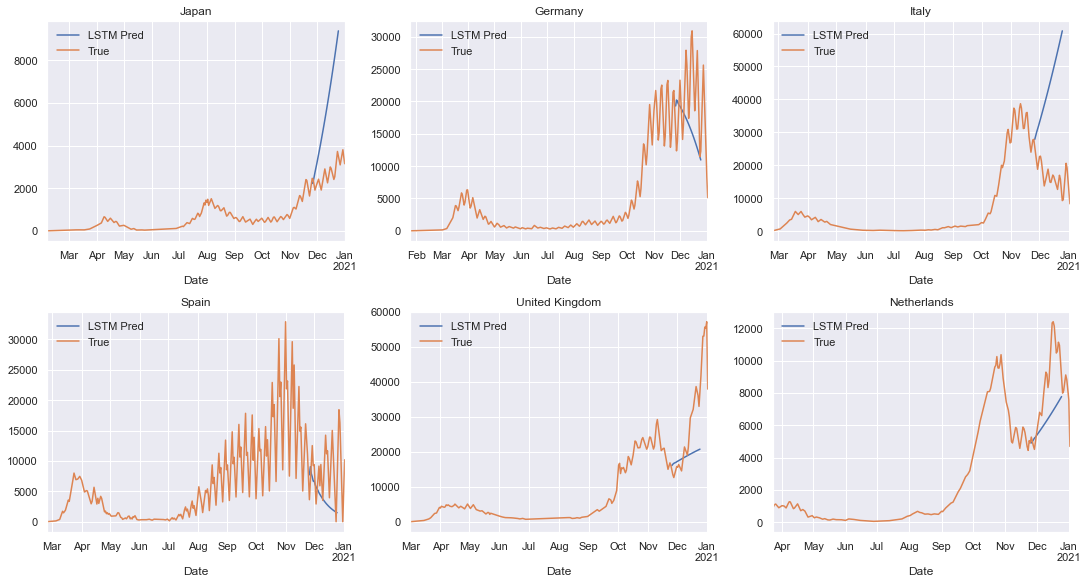

In [10]:
countries = ["Japan", "Germany", "Italy", "Spain", "United Kingdom", "Netherlands"]
nrow, ncol = 2, 3
colors = map('C{}'.format, cycle(range(nrow*ncol)))
fig, axs = plt.subplots(nrow,ncol,figsize=(ncol*5, nrow*4), constrained_layout=True);

for country, ax in zip(countries, axs.flatten()):
    res_regional[res_regional["Country/Region"] == country].plot(x="Date", y="New Confirmed", label="LSTM Pred", ax=ax)
    train_df[train_df["Country"] == country].plot(x="Date", y="New Confirmed", ax=ax, label="True", title=country);

### Make SIR predictions and insert predictions into X_test_nc at the right location (match location on country) 

In [ ]:
countries = ["Japan", "Germany", "Italy", "Spain", "United Kingdom", "Netherlands"]
# countries = ["Netherlands"]
for country in countries:
    snl = cs.Scenario(jhu_data, population_data, country=country)
    data = snl.records()
    trend = snl.trend(show_figure=False)

    # Parameter estimation of SIR model
    snl.estimate(cs.SIRF)

    # History 
    _ = snl.history_rate()
    # Simulation for n days
    snl.add(days=20)
#     _ = snl.simulate()

    plot = snl.simulate(show_figure=False);

    window = days_moving_average
    new = plot["Confirmed"].diff().dropna()
    new = new.rolling(window=window).mean().dropna().astype(np.int64)
    plot["New Confirmed"] = new
    
    # Save file temporary
    pickle.dump( plot, open( "data/SIR_" + country + ".p", "wb" ) )

### Insert SIR predictions as input for LSTM model

In [99]:
test_copy = test.copy()
countries = ["Japan", "Germany", "Italy", "Spain", "United Kingdom", "Netherlands"]
plots_list = []
    
for country in countries:
    # Load SIR data
    plot = pickle.load(open( "data/SIR_" + country + ".p", "rb" ) )
    plots_list.append(plot)
    # Number of days to add to test-set
    relative_days = 70
    look_back = 50

    # Convert data to correct format
    plot["Country/Region"] = country
    plot = plot.dropna()
    SIR_df = plot.rename(columns={"Date": "ObservationDate"})

    display(SIR_df["ObservationDate"][-look_back:(-look_back + n_steps)].values)
    print(SIR_df["New Confirmed"].values[-look_back:(-look_back + n_steps)])
    base = SIR_df["ObservationDate"][-look_back:(-look_back + n_steps)].values[0]
    ts = (base - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    ts = datetime.datetime.utcfromtimestamp(ts)

    # Replace values in the test set with new predicted values
    index=dict()
    for i in range(len(res_new_confirmed)):
        index[res_new_confirmed.iloc[i]['Country/State'][0]]=i

    X_test_nc_copy = X_test_nc.copy()
    print("Before", X_test_nc_copy[index[country]])
    X_test_nc_copy[index[country]][0] = SIR_df["New Confirmed"].values[-look_back:(-look_back + n_steps)]
    print("After",  X_test_nc_copy[index[country]])

    # Get last day SIR predictions and update testset
    delta_ns = plot.iloc[-1:]["Date"].values[0] - test.iloc[-1:]["Date"].values[0]
    days = delta_ns.astype('timedelta64[D]')
    days = int(days / np.timedelta64(1, 'D'))

for index, row in test_copy.iterrows():
    new_date = row["Date"] + datetime.timedelta(days=days + relative_days)
    test_copy.at[index,'Date'] = new_date


array(['2020-12-07T00:00:00.000000000', '2020-12-08T00:00:00.000000000',
       '2020-12-09T00:00:00.000000000', '2020-12-10T00:00:00.000000000',
       '2020-12-11T00:00:00.000000000'], dtype='datetime64[ns]')

[2207. 2232. 2256. 2242. 2301.]
Before [[8475.9765625  8774.86914062 9077.91308594 9385.11230469 9696.46972656]]
After [[2207. 2232. 2256. 2242. 2301.]]


array(['2020-12-08T00:00:00.000000000', '2020-12-09T00:00:00.000000000',
       '2020-12-10T00:00:00.000000000', '2020-12-11T00:00:00.000000000',
       '2020-12-12T00:00:00.000000000'], dtype='datetime64[ns]')

[21403. 18957. 19583. 20331. 23971.]
Before [[12312.23535156 11871.17578125 11419.25390625 10956.37402344
  10482.44238281]]
After [[21403. 18957. 19583. 20331. 23971.]]


array(['2020-12-08T00:00:00.000000000', '2020-12-09T00:00:00.000000000',
       '2020-12-10T00:00:00.000000000', '2020-12-11T00:00:00.000000000',
       '2020-12-12T00:00:00.000000000'], dtype='datetime64[ns]')

[14442. 14231. 21084. 21891. 22699.]
Before [[57003.46875    58264.56640625 59535.84375    60817.1796875
  62108.4453125 ]]
After [[14442. 14231. 21084. 21891. 22699.]]


array(['2020-12-08T00:00:00.000000000', '2020-12-09T00:00:00.000000000',
       '2020-12-10T00:00:00.000000000', '2020-12-11T00:00:00.000000000',
       '2020-12-12T00:00:00.000000000'], dtype='datetime64[ns]')

[10200.  9560.  4956.  4955.  4954.]
Before [[1781.10668945 1674.54577637 1574.21142578 1480.07189941 1391.6126709 ]]
After [[10200.  9560.  4956.  4955.  4954.]]


array(['2020-12-08T00:00:00.000000000', '2020-12-09T00:00:00.000000000',
       '2020-12-10T00:00:00.000000000', '2020-12-11T00:00:00.000000000',
       '2020-12-12T00:00:00.000000000'], dtype='datetime64[ns]')

[16066. 16031. 16391. 17231. 18296.]
Before [[20343.03125    20479.95898438 20614.96875    20747.99414062
  20878.95898438]]
After [[16066. 16031. 16391. 17231. 18296.]]


array(['2020-12-08T00:00:00.000000000', '2020-12-09T00:00:00.000000000',
       '2020-12-10T00:00:00.000000000', '2020-12-11T00:00:00.000000000',
       '2020-12-12T00:00:00.000000000'], dtype='datetime64[ns]')

[6134. 7471. 7755. 8049. 8036.]
Before [[7451.95117188 7560.68603516 7670.22070312 7780.54296875 7891.640625  ]]
After [[6134. 7471. 7755. 8049. 8036.]]


In [100]:
# Number of days to forecast
num_days = 20

pivot_date = f"'{ts.date()}'"
print(pivot_date)
forcast_start_date = pivot_date.replace("'", "")
new_confirmed_SIR = forcast(model_nc,X_test_nc_copy,forcast_start_date,num_days, n_steps, regs)

begin_date = f"'{forcast_start_date}'"
begin_date = pivot_date
end_date = f"'{new_confirmed_SIR.columns[-2:][0]}'"
sub, res_regional = convert_predictions_df(new_confirmed_SIR,test_copy, begin_date, end_date)
# sub, res_regional = convert_predictions_df(new_confirmed_SIR, test_copy, begin_date, end_date)
# res_country = res_regional[res_regional["Country/Region"] == country]

# Append to existing predictions
# date_list = [ts - datetime.timedelta(days=x) for x in range(num_days)]
# res_country["Date"] = date_list

'2020-12-08'


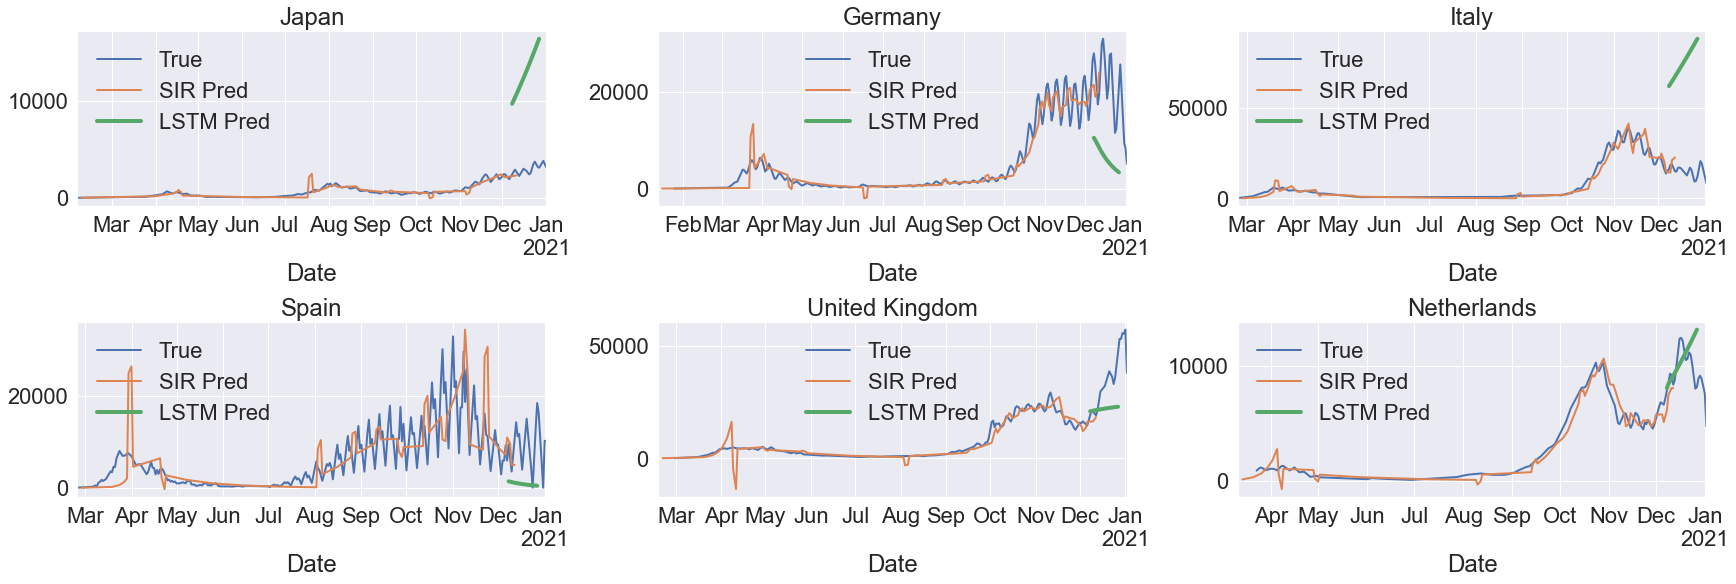

In [101]:
# sns.set(rc={'figure.figsize':(10.7,7.27)})
# sns.set(font_scale=2)
l = list(range(0, len(countries)))
nrow, ncol = 2, 3
colors = map('C{}'.format, cycle(range(nrow*ncol)))
fig, axs = plt.subplots(nrow,ncol,figsize=(ncol*8, nrow*4), constrained_layout=True);

for country, ax, index in zip(countries, axs.flatten(), l):
    res_country = res_regional[res_regional["Country/Region"] == country]
    train_df[train_df["Country"] == country].plot(x="Date", y="New Confirmed", label="True",  linewidth=2, ax=ax)
    plots_list[index].iloc[:-45].plot(x="Date", y="New Confirmed", label="SIR Pred", title=country, ax=ax, linewidth=2)
    res_country.plot(x="Date", y="New Confirmed", label="LSTM Pred", ax=ax,  linewidth=4);
    
    

In [102]:
plot

,Date,Confirmed,Fatal,Infected,Recovered,New Confirmed,Country/Region
3,2020-03-14,794,23,736,35,105.0,Netherlands
4,2020-03-15,935,31,854,50,122.0,Netherlands
5,2020-03-16,1099,41,990,68,142.0,Netherlands
6,2020-03-17,1288,52,1148,88,164.0,Netherlands
7,2020-03-18,1508,65,1331,112,191.0,Netherlands
...,...,...,...,...,...,...,...
317,2021-01-22,919846,12614,51382,855850,3825.0,Netherlands
318,2021-01-23,923388,12648,49473,861267,3682.0,Netherlands
319,2021-01-24,926799,12682,47634,866483,3544.0,Netherlands
320,2021-01-25,930082,12714,45863,871505,3412.0,Netherlands


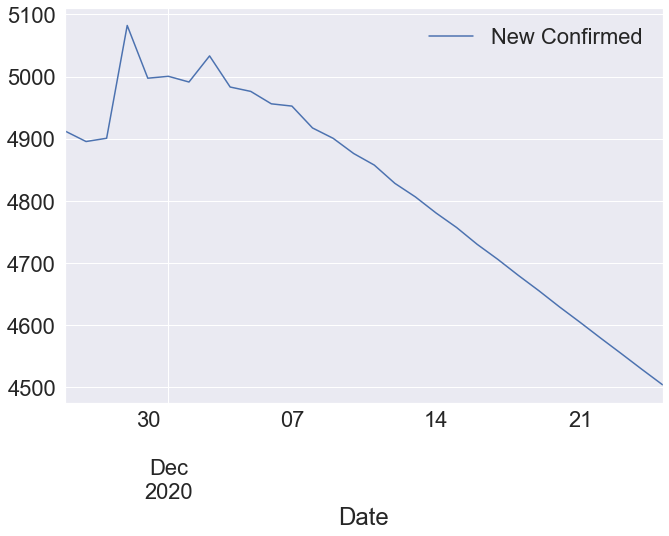

In [115]:
res_regional[res_regional["Country/Region"] == "Netherlands"].plot(x="Date", y="New Confirmed")

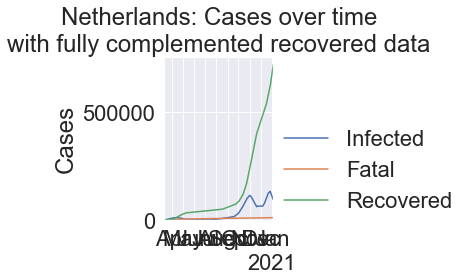


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...
	 1st phase (06Apr2020 - 28Apr2020): finished 1461 trials in 3 min  7 sec
Completed optimization. Total: 3 min  8 sec


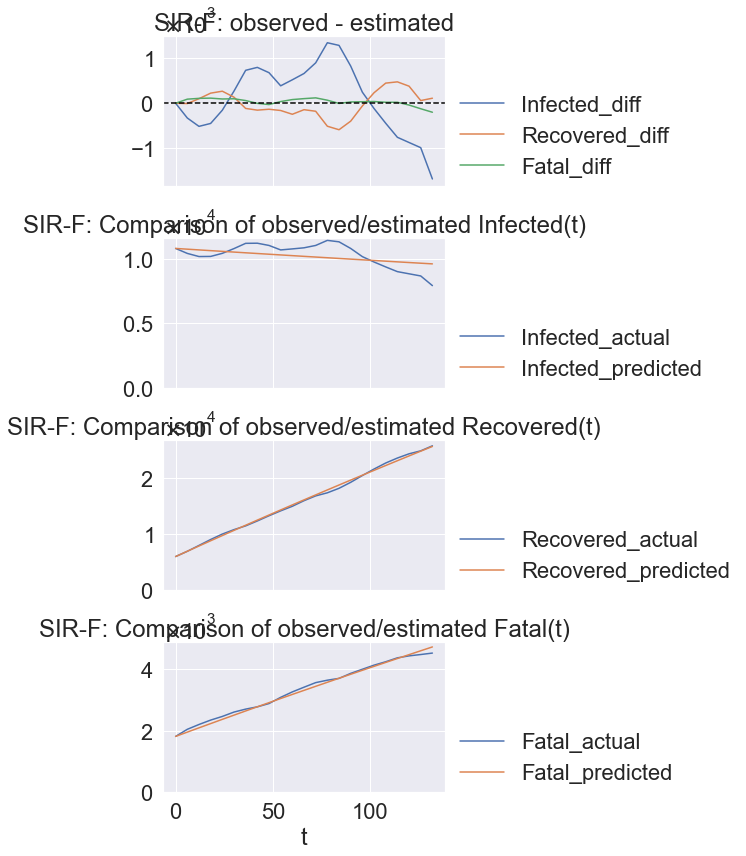

,Confirmed,Infected_actual,Fatal_actual,Recovered_actual,Susceptible_actual,Susceptible_predicted,Infected_predicted,Recovered_predicted,Fatal_predicted,Infected_diff,Recovered_diff,Fatal_diff
t,,,,,,,,,,,,
0,18609,10809,1818,5982,17213015,17213015.0,10809.0,5982.0,1818.0,0.0,0.0,0.0
6,19391,10424,2049,6918,17212233,17211990.0,10752.0,6924.0,1958.0,-328.0,-6.0,91.0
12,20350,10181,2206,7963,17211274,17210970.0,10695.0,7862.0,2097.0,-514.0,101.0,109.0
18,21559,10190,2349,9020,17210065,17209955.0,10639.0,8795.0,2235.0,-449.0,225.0,114.0
24,22886,10428,2468,9990,17208738,17208946.0,10583.0,9722.0,2373.0,-155.0,268.0,95.0
30,24187,10797,2610,10780,17207437,17207942.0,10527.0,10645.0,2510.0,270.0,135.0,100.0
36,25358,11204,2706,11448,17206266,17206944.0,10471.0,11563.0,2646.0,733.0,-115.0,60.0
42,26317,11214,2780,12323,17205307,17205951.0,10416.0,12476.0,2782.0,798.0,-153.0,-2.0
48,27179,11041,2887,13251,17204445,17204963.0,10361.0,13384.0,2916.0,680.0,-133.0,-29.0


In [118]:
country="Netherlands"
snl = cs.Scenario(jhu_data, population_data, country=country)
data = snl.records()
trend = snl.trend(show_figure=False)
snl.estimate(cs.SIRF, phases=["1st"])
df = snl.phase_estimator(phase="1st").accuracy()
df